# Phylogenetic Tree Construction for Antibody Sequences

This notebook demonstrates how to construct phylogenetic trees from antibody sequences using single-cell immune repertoire data. We'll use the scirpy library for immune repertoire analysis, and BioPython for sequence alignment and phylogenetic tree construction.

## Overview of the workflow:
1. **Data preparation**: Load and process immune repertoire data with scirpy
2. **Clonotype analysis**: Identify and select the largest clonotype for analysis
3. **Sequence extraction**: Extract heavy chain sequences and save as FASTA
4. **Multiple sequence alignment**: Align sequences using ClustalOmega
5. **Phylogenetic reconstruction**: Build neighbor-joining tree using distance matrices
6. **Visualization**: Display the resulting phylogenetic tree

## Prerequisites:
- ClustalOmega must be installed (`conda install -c bioconda clustalo`)
- Required Python packages: scirpy, scanpy, muon, pandas, biopython, matplotlib


In [1]:
# =============================================================================
# STEP 0: Import all necessary libraries
# =============================================================================

# Core immune repertoire analysis libraries
import scirpy as ir          # Single-cell immune repertoire analysis
import scanpy as sc          # Single-cell analysis toolkit
import muon as mu            # Multi-modal omics analysis

# Data manipulation and file handling
import pandas as pd          # Data manipulation and analysis
import os                    # Operating system interface

# BioPython modules for sequence analysis and phylogenetics
from Bio.Align.Applications import ClustalOmegaCommandline  # ClustalOmega wrapper
from Bio import AlignIO                                     # Alignment I/O operations
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor  # Phylogenetic tools
from Bio import Phylo                                       # Phylogenetic tree handling

# Visualization libraries
import matplotlib.pyplot as plt  # Plotting library
from matplotlib.lines import Line2D  # Custom legend elements

print("All libraries imported successfully!")
print("Ready to begin phylogenetic analysis of antibody sequences.")


All libraries imported successfully!
Ready to begin phylogenetic analysis of antibody sequences.


/home/wqzhao/anaconda3/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
# =============================================================================
# STEP 1: Data preparation and clonotype identification using Scirpy
# =============================================================================

print("=== STEP 1: Preparing immune repertoire data with Scirpy ===")
print("Loading sample dataset and performing quality control...")

# Load the Stephenson et al. 2021 dataset (5k cells subset)
# This dataset contains paired single-cell RNA-seq and immune repertoire data
mdata = ir.datasets.stephenson2021_5k()
print(f"Loaded dataset with {mdata.n_obs} cells")

# Perform chain-level quality control
# This step filters out low-quality immune receptor sequences
# and calculates various QC metrics for each chain
print("\nPerforming chain-level quality control...")
ir.tl.chain_qc(mdata)

# Calculate pairwise distances between immune receptor sequences
# Using normalized Hamming distance on nucleotide sequences
# This distance metric accounts for sequence length differences
print("Calculating pairwise sequence distances...")
ir.pp.ir_dist(mdata, metric="normalized_hamming", sequence="nt")

# Define clonotype clusters based on sequence similarity
# Cells with similar immune receptor sequences are grouped into clonotypes
print("Defining clonotype clusters...")
ir.tl.define_clonotype_clusters(
    mdata,
    sequence="nt",                    # Use nucleotide sequences
    metric="normalized_hamming",      # Distance metric for clustering
    receptor_arms="all",              # Consider all receptor chains (heavy and light)
    dual_ir="any",                    # Allow cells with multiple chains
    same_v_gene=True,                 # Require same V gene for clustering
    key_added="clone_id_85_similarity", # Column name for cluster assignments
)

# Identify the largest clonotype for detailed analysis
# Larger clonotypes provide more sequences for robust phylogenetic analysis
clone_counts = mdata.obs["airr:clone_id_85_similarity"].value_counts()
largest_clone_id = clone_counts.index[0]
n_cells_in_clone = clone_counts.iloc[0]

print(f"\n✓ Scirpy analysis completed successfully!")
print(f"  - Total clonotypes identified: {len(clone_counts)}")
print(f"  - Largest clonotype ID: '{largest_clone_id}'")
print(f"  - Number of cells in largest clonotype: {n_cells_in_clone}")

# Subset the data to include only cells from the largest clonotype
# This creates a focused dataset for phylogenetic analysis
print(f"\nSubsetting data to clonotype '{largest_clone_id}'...")
mdata_clone = mdata[mdata.obs["airr:clone_id_85_similarity"] == largest_clone_id, :].copy()
adata_airr_clone = mdata_clone.mod['airr']  # Extract the AIRR (immune repertoire) modality

print(f"✓ Created subset with {mdata_clone.n_obs} cells for phylogenetic analysis")


=== STEP 1: Preparing immune repertoire data with Scirpy ===
Loading sample dataset and performing quality control...


/home/wqzhao/anaconda3/lib/python3.11/site-packages/anndata/utils.py:354: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)
/home/wqzhao/anaconda3/lib/python3.11/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/wqzhao/anaconda3/lib/python3.11/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will b

Loaded dataset with 5000 cells

Performing chain-level quality control...
Calculating pairwise sequence distances...


/home/wqzhao/anaconda3/lib/python3.11/site-packages/scirpy/ir_dist/metrics.py:733: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  data_rows[row_index][0] = data_row_matrix[thread_id, 0:row_end_index].copy()


Defining clonotype clusters...

✓ Scirpy analysis completed successfully!
  - Total clonotypes identified: 4853
  - Largest clonotype ID: '9'
  - Number of cells in largest clonotype: 17

Subsetting data to clonotype '9'...
✓ Created subset with 17 cells for phylogenetic analysis


/home/wqzhao/anaconda3/lib/python3.11/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/wqzhao/anaconda3/lib/python3.11/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [3]:
# =============================================================================
# STEP 2: Extract heavy chain sequences and create FASTA file
# =============================================================================

print("\n=== STEP 2: Extracting heavy chain sequences ===")
print("Processing immune receptor data to extract IGH sequences...")

# Define output filename for the FASTA file
fasta_filename = "clone_sequences.fasta"
cell_sequences = {}  # Dictionary to store cell_id -> sequence mappings

# Access the AIRR data structure and cell identifiers
# AIRR data contains detailed information about each immune receptor chain
airr_data = adata_airr_clone.obsm["airr"]  # AIRR data matrix
cell_ids = adata_airr_clone.obs.index      # Cell identifiers

print(f"Processing {len(adata_airr_clone)} cells...")

# Iterate through each cell to extract heavy chain sequences
sequences_found = 0
for i in range(len(adata_airr_clone)):
    # 1. Get the cell ID from the observation index
    cell_id = cell_ids[i]
    
    # 2. Retrieve all immune receptor chain records for this cell
    # Each cell may have multiple chains (heavy, light, etc.)
    record_for_cell = airr_data[i]
    
    # 3. Identify heavy chain records (IGH locus)
    # IGH = Immunoglobulin Heavy chain
    # We focus on heavy chains as they undergo more somatic hypermutation
    # and provide better phylogenetic signal
    is_igh_in_record = (record_for_cell['locus'] == 'IGH')
    
    # 4. Extract sequences from heavy chain records
    igh_sequences_for_cell = record_for_cell['sequence'][is_igh_in_record]
    
    # 5. Store the first heavy chain sequence found
    # Note: Some cells may have multiple heavy chains due to doublets or
    # technical artifacts; we take the first one for simplicity
    if len(igh_sequences_for_cell) > 0:
        sequence = igh_sequences_for_cell[0]
        
        # Validate that the sequence is not empty or invalid
        if sequence and len(sequence) > 0 and sequence != 'None':
            cell_sequences[cell_id] = sequence
            sequences_found += 1

print(f"Found {sequences_found} valid heavy chain sequences")

# Write sequences to FASTA format file
# FASTA format: >header\nsequence\n for each sequence
print(f"Writing sequences to '{fasta_filename}'...")
with open(fasta_filename, "w") as f:
    for cell_id, sequence in cell_sequences.items():
        # Write FASTA header (cell ID)
        f.write(f">{cell_id}\n")
        # Write sequence data
        f.write(f"{sequence}\n")

print(f"✓ Successfully wrote {len(cell_sequences)} sequences to '{fasta_filename}'")
print(f"  - File size: {os.path.getsize(fasta_filename)} bytes")
print(f"  - Ready for multiple sequence alignment")



=== STEP 2: Extracting heavy chain sequences ===
Processing immune receptor data to extract IGH sequences...
Processing 17 cells...
Found 17 valid heavy chain sequences
Writing sequences to 'clone_sequences.fasta'...
✓ Successfully wrote 17 sequences to 'clone_sequences.fasta'
  - File size: 11612 bytes
  - Ready for multiple sequence alignment


In [4]:
# =============================================================================
# STEP 3: Multiple sequence alignment using ClustalOmega
# =============================================================================

print("\n=== STEP 3: Multiple sequence alignment and phylogenetic reconstruction ===")

# Define output filename for aligned sequences
aligned_fasta_filename = "clone_sequences_aligned.fasta"
tree_construction_success = False

try:
    print("Performing multiple sequence alignment with ClustalOmega...")
    print("  - Algorithm: Progressive alignment with guide trees")
    print("  - This step may take several minutes for large sequence sets")
    
    # Set up ClustalOmega command line interface
    # ClustalOmega is a fast and accurate multiple sequence alignment tool
    cline = ClustalOmegaCommandline(
        infile=fasta_filename,           # Input FASTA file
        outfile=aligned_fasta_filename,  # Output aligned FASTA file
        verbose=True,                    # Verbose output for monitoring progress
        auto=True,                       # Automatic parameter optimization
        force=True                       # Overwrite existing output files
    )
    
    # Execute the alignment
    stdout, stderr = cline()
    print("✓ Multiple sequence alignment completed successfully")
    
    # =============================================================================
    # STEP 4: Distance matrix calculation and phylogenetic tree construction
    # =============================================================================
    
    print("\nCalculating evolutionary distances...")
    
    # Read the aligned sequences
    with open(aligned_fasta_filename, "r") as handle:
        aln = AlignIO.read(handle, "fasta")
    
    print(f"  - Alignment length: {aln.get_alignment_length()} positions")
    print(f"  - Number of sequences: {len(aln)}")
    
    # Calculate pairwise distances using identity metric
    # Identity metric: proportion of identical positions in aligned sequences
    # Distance = 1 - identity (higher values = more divergent sequences)
    calculator = DistanceCalculator('identity')
    distance_matrix = calculator.get_distance(aln)
    print("✓ Distance matrix calculated")
    
    print("\nConstructing phylogenetic tree using Neighbor-Joining method...")
    print("  - Method: Neighbor-Joining (NJ)")
    print("  - NJ is fast and generally accurate for closely related sequences")
    print("  - Tree will be rooted at midpoint for visualization")
    
    # Build phylogenetic tree using Neighbor-Joining algorithm
    # NJ is a distance-based method that's computationally efficient
    # and works well for immune receptor sequences
    constructor = DistanceTreeConstructor(calculator, 'nj')
    tree = constructor.build_tree(aln)
    
    # Root the tree at its midpoint for better visualization
    # Midpoint rooting places the root at the midpoint of the longest path
    tree.root_at_midpoint()
    
    tree_construction_success = True
    print("✓ Phylogenetic tree construction completed successfully")
    print(f"  - Tree contains {len(tree.get_terminals())} terminal nodes (sequences)")
    print(f"  - Tree contains {len(tree.get_nonterminals())} internal nodes")

except FileNotFoundError:
    print("\n❌ ERROR: ClustalOmega ('clustalo') command not found")
    print("   Please install ClustalOmega using:")
    print("   conda install -c bioconda clustalo")
    print("   Or install via your system package manager")
    
except Exception as e:
    print(f"\n❌ ERROR during alignment or tree construction: {e}")
    print("   This could be due to:")
    print("   - Invalid sequences in the input file")
    print("   - Insufficient memory for large datasets")
    print("   - ClustalOmega installation issues")

if tree_construction_success:
    print("\n✓ Ready for tree visualization in the next step")
else:
    print("\n⚠ Tree construction failed - visualization will be skipped")



=== STEP 3: Multiple sequence alignment and phylogenetic reconstruction ===
Performing multiple sequence alignment with ClustalOmega...
  - Algorithm: Progressive alignment with guide trees
  - This step may take several minutes for large sequence sets
✓ Multiple sequence alignment completed successfully

Calculating evolutionary distances...
  - Alignment length: 667 positions
  - Number of sequences: 17
✓ Distance matrix calculated

Constructing phylogenetic tree using Neighbor-Joining method...
  - Method: Neighbor-Joining (NJ)
  - NJ is fast and generally accurate for closely related sequences
  - Tree will be rooted at midpoint for visualization
✓ Phylogenetic tree construction completed successfully
  - Tree contains 17 terminal nodes (sequences)
  - Tree contains 16 internal nodes

✓ Ready for tree visualization in the next step


=== STEP 5: Visualizing the phylogenetic tree ===
Rendering phylogenetic tree...
  - Layout: Rectangular (cladogram style)
  - Branch lengths represent evolutionary distances
  - Terminal nodes represent individual cell sequences


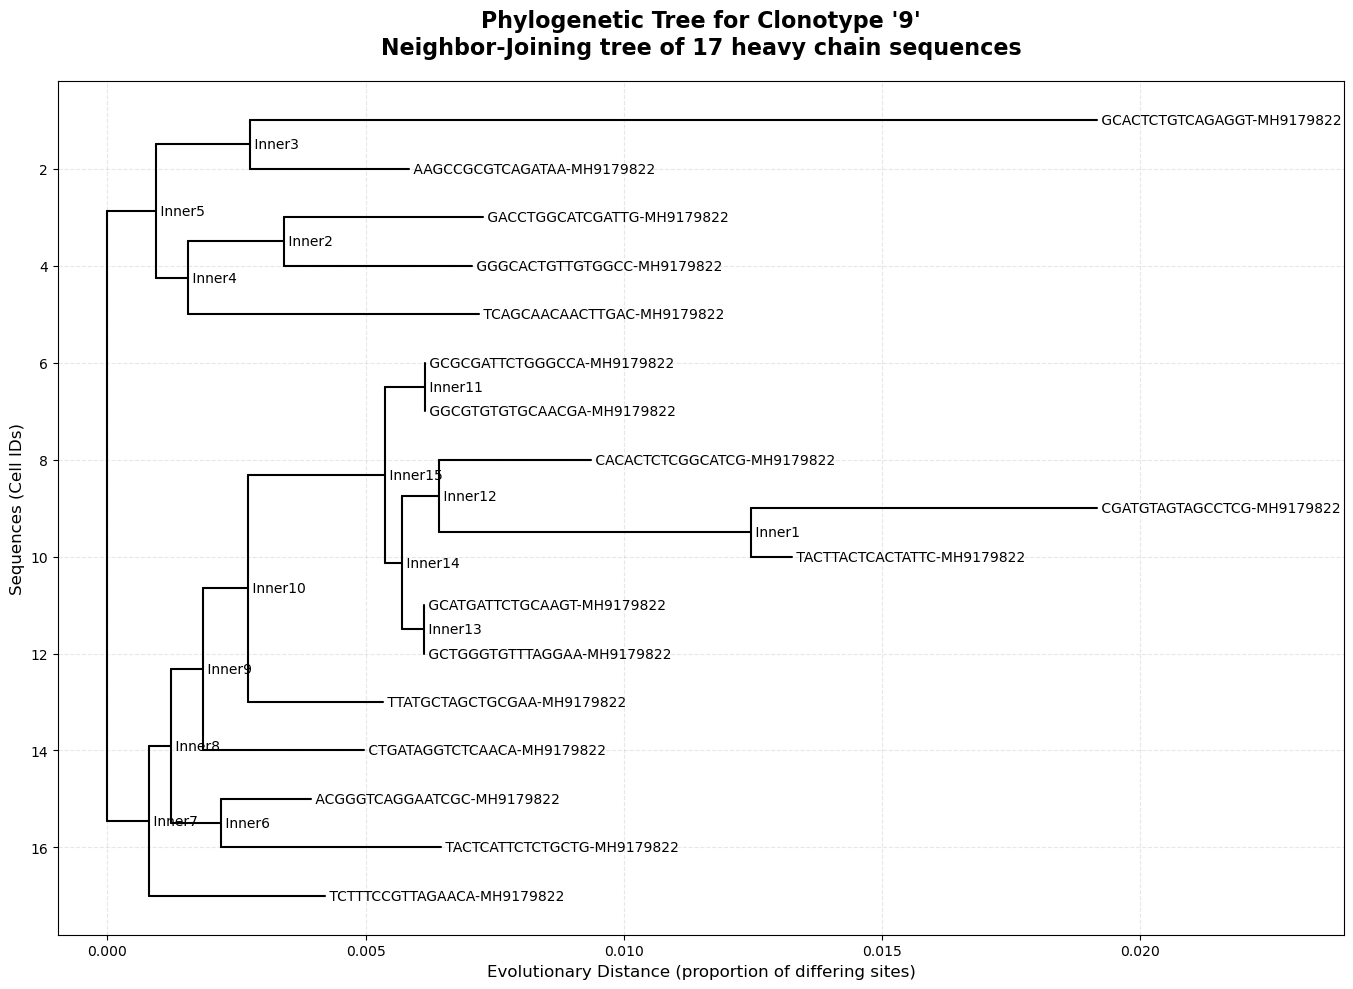


✓ Phylogenetic tree visualization completed!

Interpretation guide:
  • Branch lengths = evolutionary distances between sequences
  • Shorter branches = more similar sequences
  • Nodes closer together = more recently diverged
  • This tree shows the evolutionary relationships within the clonotype
  • Sequences may represent somatic hypermutation variants

Potential follow-up analyses:
  1. Analyze mutation patterns along branches
  2. Correlate tree structure with cell phenotypes
  3. Identify germline and most mutated sequences
  4. Compare trees across different clonotypes

PHYLOGENETIC ANALYSIS PIPELINE COMPLETED


In [5]:
# =============================================================================
# STEP 5: Phylogenetic tree visualization
# =============================================================================

if tree_construction_success:
    print("=== STEP 5: Visualizing the phylogenetic tree ===")
    
    # Create a large figure for detailed tree visualization
    fig, ax = plt.subplots(figsize=(14, 10))
    
    print("Rendering phylogenetic tree...")
    print("  - Layout: Rectangular (cladogram style)")
    print("  - Branch lengths represent evolutionary distances")
    print("  - Terminal nodes represent individual cell sequences")
    
    # Draw the phylogenetic tree
    # BioPython's Phylo.draw creates a matplotlib-based tree visualization
    Phylo.draw(
        tree,           # The phylogenetic tree object
        axes=ax,        # Matplotlib axes for drawing
        do_show=False   # Don't show immediately (we'll customize first)
    )
    
    # Customize the plot appearance
    ax.set_title(
        f"Phylogenetic Tree for Clonotype '{largest_clone_id}'\n"
        f"Neighbor-Joining tree of {n_cells_in_clone} heavy chain sequences",
        fontsize=16,
        fontweight='bold',
        pad=20
    )
    
    # Add informative axis labels
    ax.set_xlabel("Evolutionary Distance (proportion of differing sites)", fontsize=12)
    ax.set_ylabel("Sequences (Cell IDs)", fontsize=12)
    
    # Add a grid for easier reading of distances
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Improve layout and spacing
    plt.tight_layout()
    
    # Display the tree
    plt.show()
    
    print("\n✓ Phylogenetic tree visualization completed!")
    print("\nInterpretation guide:")
    print("  • Branch lengths = evolutionary distances between sequences")
    print("  • Shorter branches = more similar sequences")
    print("  • Nodes closer together = more recently diverged")
    print("  • This tree shows the evolutionary relationships within the clonotype")
    print("  • Sequences may represent somatic hypermutation variants")
    
    # Provide additional analysis suggestions
    print("\nPotential follow-up analyses:")
    print("  1. Analyze mutation patterns along branches")
    print("  2. Correlate tree structure with cell phenotypes")
    print("  3. Identify germline and most mutated sequences")
    print("  4. Compare trees across different clonotypes")
    
else:
    print("\n⚠ Skipping visualization due to failed tree construction")
    print("   Please resolve the alignment/tree building issues first")

print("\n" + "="*80)
print("PHYLOGENETIC ANALYSIS PIPELINE COMPLETED")
print("="*80)
